In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') #fivethirtyeight
%matplotlib inline

import itertools
import os

from scipy.stats import boxcox
from scipy.special import inv_boxcox

import fbprophet

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric, plot_plotly
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

import plotly.graph_objects as go
import plotly

plotly.offline.init_notebook_mode(connected=True)

import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
logging.getLogger('pystan').setLevel(logging.ERROR)

import warnings
import sys

warnings.filterwarnings('ignore')
sys.path.append('../functions')

from tsplot import tsplot
from supress import suppress_stdout_stderr

import textwrap

figsize = (17, 8)

### Created functions

In [21]:
def changepoints_gov_plot(data, changepoints, gov_actions, yax='', title='', data_title='Data', changepoints_title='Changepoints', gov_title='Government actions'):
    shapes = list()
    
    for i in range(len(changepoints)):
        shapes.append({'type': 'line',
                       'name': 'Changepoint',
                       'line': dict(
                                color="Green",
                                width=2,
                                dash="dash"),
                       'xref': 'x',
                       'yref': 'y',
                       'x0': changepoints['ds'][i],
                       'y0': changepoints['y'][i] - 10000,
                       'x1': changepoints['ds'][i],
                       'y1': changepoints['y'][i] + 10000})
        
    layout = go.Layout(shapes=shapes)
    
    fig = go.Figure(layout=layout)
    
    fig.update_layout(
        autosize=False,
        width=1500,
        height=1000,
        title=title)
    
    fig.update_yaxes(title=yax)
    fig.update_xaxes(title='Date')
    
    fig.add_trace(go.Scatter(x=data.ds, 
                             y=data.y,
                             name=data_title
                               ))
    
    fig.add_trace(go.Scatter(x=gov_actions.start, 
                             y=gov_actions['y'],
                             text=gov_actions['Description'],
                             name=gov_title, 
                             mode="markers",
                             textposition="top left"))
    
    fig.add_trace(go.Scatter(x=changepoints['ds'], 
                         y=changepoints['y'],
                         name=changepoints_title, mode='markers',
                           ))

    for i in range(len(gov_actions)):
        # Add text notations of government actions to the plot
        fig.add_annotation(
                x=gov_actions.start[i],
                y=gov_actions['y'][i],
                xref="x",
                yref="y",
                text=gov_actions['Description'][i],
                showarrow=True,
                font=dict(
                    family="Courier New, monospace",
                    size=18,
                    color="#000000"
                    ),
                align="center",
                arrowhead=1,
                arrowsize=1,
                arrowwidth=1,
                arrowcolor="#636363",
                ax=-50 * ((-1) ** i),
                ay=-50 * ((-1) ** i),
                bordercolor="#c7c7c7",
                borderwidth=2,
                borderpad=4,
                bgcolor="#ff7f0e",
                opacity=0.8
                )
            
    config = dict({'editable': True})

    fig.show(config=config)

### Data preparation

In [3]:
# Data set with government actions
opatreni = pd.read_csv('../opatreni-04-05.csv', delimiter=';').drop(['Unnamed: 3'], axis=1)[:53]
opatreni['start'] = pd.to_datetime(opatreni['start'], format='%d.%m.%Y')
opatreni['end'] = pd.to_datetime(opatreni['end'], format='%d.%m.%Y')
opatreni.tail()

,start,end,Description
48,2021-03-15,NaT,the government has approved mandatory testing ...
49,2021-03-22,NaT,extended the lockdown announced by the governm...
50,2021-04-07,NaT,"the current Minister of Health, Jan Blatný, wa..."
51,2021-04-12,NaT,part of the measures have been loosened
52,2021-05-03,NaT,Rotary teaching of secondary school pupils in ...


In [4]:
# Data set with amount of people infected data
data = pd.read_csv('../data/nakazeni-vyleceni-umrti-testy-04-05.csv')
data['datum'] = pd.to_datetime(data['datum'])
# Original data time series (Comulative amount of infected)
infected = data[['datum', 'kumulativni_pocet_nakazenych']]
# Rename columns into Prophet standart
infected.columns = ['ds', 'y']
infected.head()

,ds,y
0,2020-01-27,0
1,2020-01-28,0
2,2020-01-29,0
3,2020-01-30,0
4,2020-01-31,0


In [10]:
for i in range(len(changepoints.ds)):
    if i == 0:
        mean_new_cases = np.mean(infected_diff[infected_diff['ds'] < "2020-04-06"]['y'])
        print(f'2020-03-01 - {changepoints["ds"][i]}: mean amount of new cases = {mean_new_cases:0.1f}')
        mean_new_cases = np.mean(infected_diff[(changepoints['ds'][i] <= infected_diff['ds']) & (infected_diff['ds'] < changepoints['ds'][i+1])]['y'])
        print(f'{changepoints["ds"][i]} - {changepoints["ds"][i+1]}: mean amount of new cases = {mean_new_cases:0.1f}')
    elif i == len(changepoints.ds) - 1:
        mean_new_cases = np.mean(infected_diff[(changepoints['ds'][i] <= infected_diff['ds']) & (infected_diff['ds'] < "2021-05-03")]['y'])
        print(f'{changepoints["ds"][i]} - 2020-05-03: mean amount of new cases = {mean_new_cases:0.1f}')
    else:
        mean_new_cases = np.mean(infected_diff[(changepoints['ds'][i] <= infected_diff['ds']) & (infected_diff['ds'] < changepoints['ds'][i+1])]['y'])
        print(f'{changepoints["ds"][i]} - {changepoints["ds"][i+1]}: mean amount of new cases = {mean_new_cases:0.1f}')

2020-03-01 - 2020-04-06: mean amount of new cases = 65.7
2020-04-06 - 2020-04-21: mean amount of new cases = 154.3
2020-04-21 - 2020-05-06: mean amount of new cases = 66.5
2020-05-06 - 2020-05-21: mean amount of new cases = 55.8
2020-05-21 - 2020-06-05: mean amount of new cases = 52.4
2020-06-05 - 2020-06-20: mean amount of new cases = 61.0
2020-06-20 - 2020-07-04: mean amount of new cases = 136.5
2020-07-04 - 2020-07-19: mean amount of new cases = 102.1
2020-07-19 - 2020-08-03: mean amount of new cases = 194.7
2020-08-03 - 2020-08-18: mean amount of new cases = 227.7
2020-08-18 - 2020-09-02: mean amount of new cases = 327.7
2020-09-02 - 2020-09-17: mean amount of new cases = 1060.1
2020-09-17 - 2020-10-02: mean amount of new cases = 2216.1
2020-10-02 - 2020-10-17: mean amount of new cases = 5723.9
2020-10-17 - 2020-11-01: mean amount of new cases = 11665.0
2020-11-01 - 2020-11-16: mean amount of new cases = 8337.3
2020-11-16 - 2020-12-01: mean amount of new cases = 4209.7
2020-12-01 -

In [11]:
# Gov. act. ds formatting for ploting
value = pd.DataFrame(infected[infected['ds'].isin(opatreni.start)]['y']).rename({'y': 'value'}).reset_index().drop(['index'], axis=1)
opatreni_plot = pd.concat([opatreni, value], axis=1)
opatreni_plot['Description'] = opatreni_plot['Description'].apply(
    lambda t: "<br>".join(textwrap.wrap(t))
)
opatreni_plot.head()

,start,end,Description,y
0,2020-03-02,NaT,Measures to reduce the risks of cross-border m...,3
1,2020-03-11,NaT,"All primary, secondary, higher vocational and ...",95
2,2020-03-12,2020-04-11,"On March 12, from 2 pm, a state of emergency w...",117
3,2020-03-14,2020-03-24,The operation of restaurants and shops was ban...,190
4,2020-03-16,NaT,"State borders have been closed, with few excep...",384


In [12]:
# Changepoints data
changepoints = pd.read_csv('../data/changepoints-04-05.csv').drop(['Unnamed: 0'], axis=1)
c_value = pd.DataFrame(infected[infected['ds'].isin(changepoints.ds)]['y']).rename({'y': 'value'}).reset_index().drop(['index'], axis=1)
changepoints_plot = pd.concat([changepoints, c_value], axis=1)
changepoints_plot['ds'] = pd.to_datetime(changepoints_plot['ds'])
changepoints_plot.head()

,ds,y
0,2020-04-06,4834
1,2020-04-21,7045
2,2020-05-06,7989
3,2020-05-21,8782
4,2020-06-05,9568


### Amount of infected ts visualization with trend changepoints and government actions

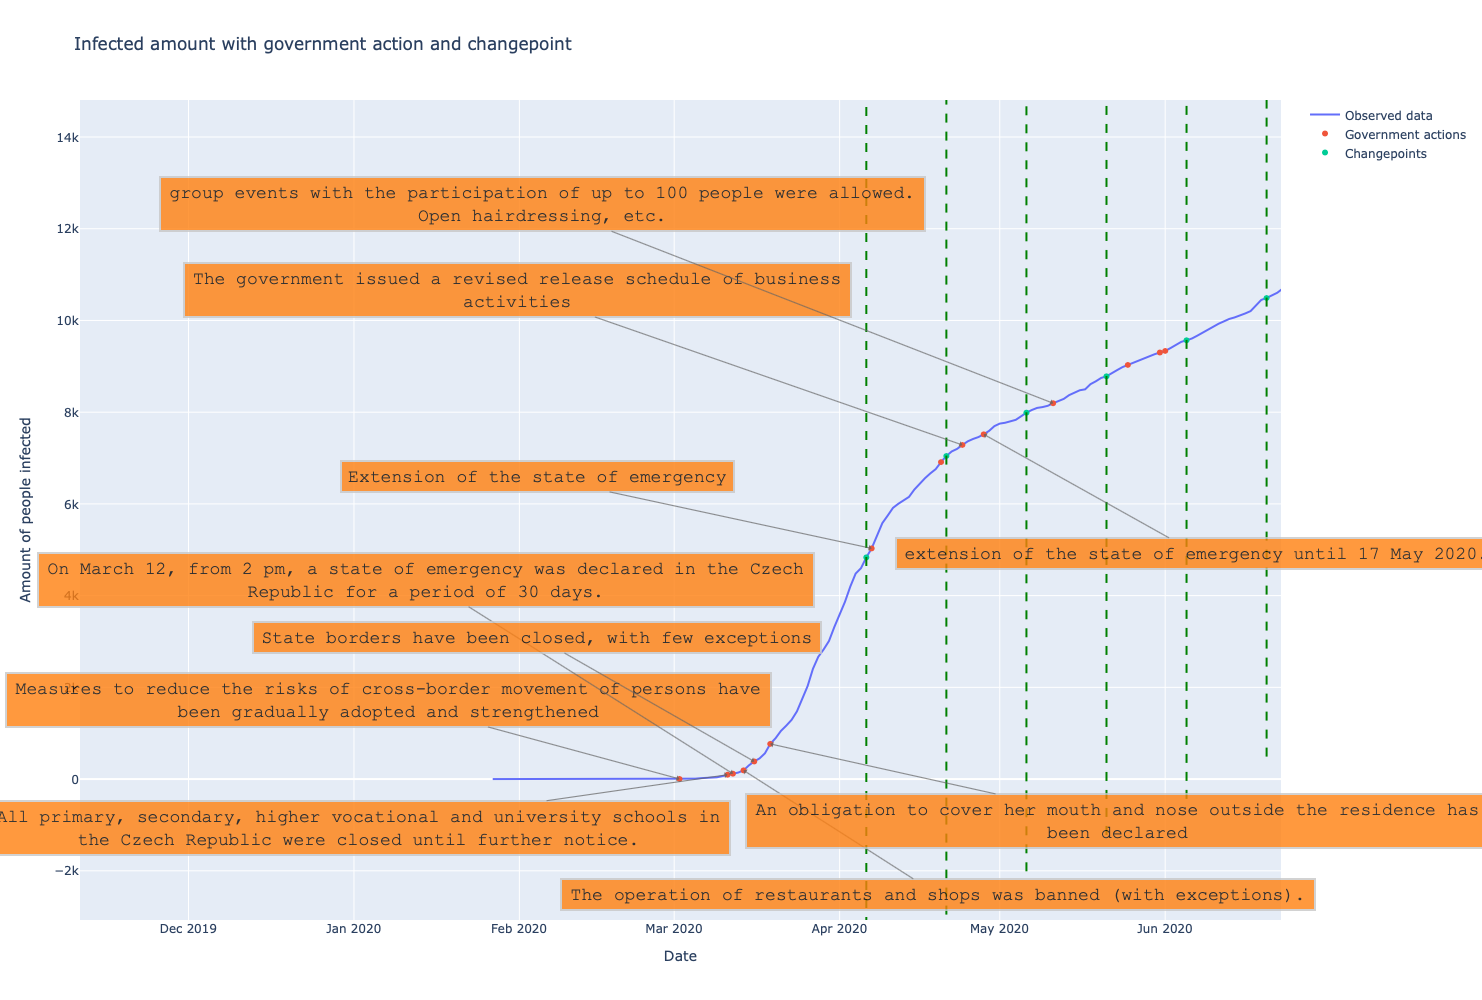

In [24]:
# Plot
changepoints_gov_plot(infected[:150], changepoints_plot[:10], opatreni_plot[:15], 
                      yax='Amount of people infected', title='Infected amount with government action and changepoint',
                     data_title='Observed data', changepoints_title='Changepoints', gov_title='Government actions')